In [0]:
# Importing the required libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Checking if the GPU is available or not

use_cuda = True
torch.cuda.is_available()

True

In [0]:
# Function to plot the graphs having multiple classes. This function is mainly used to plot iris dataset after performing PCA

def plot_graph(X,y,numClasses = 2):
  plt.figure(figsize=(8,8))
  for i in range(numClasses):
    X_cord = []
    y_cord = []
    for j in range(len(y)):
      if(y[j] == i):
        X_cord.append(X[j][0])
        y_cord.append(X[j][1])
    plt.scatter(X_cord,y_cord,s=80,marker="o",edgecolors="w")
    plt.xlabel("principal-component-1")
    plt.ylabel("principal-component-2")
    plt.title("Graph showing principal components for iris dataset")
    plt.legend(["Iris-setosa","Iris-versicolor","Iris-virginica"])

In [0]:
# Function to creates batches of images. The batch_size argument of the function allows us to create batches of variable sizes.
# Takes the Xtrain, Xtest, ytrain and ytest as its arguments and returns the corresponding image batches.

def get_batch(Xtrain, Xtest, ytrain, ytest,batch_size):
  batch_train_images = []
  batch_train_labels = []
  batch_test_images = []
  batch_test_labels = []

  for i in range(0,60000,batch_size):
    batch_train_images.append(Xtrain[i:i+batch_size])
    batch_train_labels.append(ytrain[i:i+batch_size])

  
  for i in range(0,10000,batch_size):
    batch_test_images.append(Xtest[i:i+batch_size])
    batch_test_labels.append(ytest[i:i+batch_size])

  return batch_train_images, batch_test_images, batch_train_labels, batch_test_labels

In [0]:
# Downloading the iris dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])

In [8]:
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [0]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [10]:
# Performing Feature Scaling on the dataset perfoming applying PCA

sc_X = StandardScaler()
X = sc_X.fit_transform(X)
lab_y = LabelEncoder()
y = lab_y.fit_transform(y)
y = y.reshape(-1,1)
y.shape

(150, 1)

In [0]:
# Performing PCA on the 4 components of the dataset

pca = PCA(n_components=4)
principalComponents = pca.fit_transform(X)

In [0]:
whole = np.append(arr=principalComponents,values=y,axis=1)

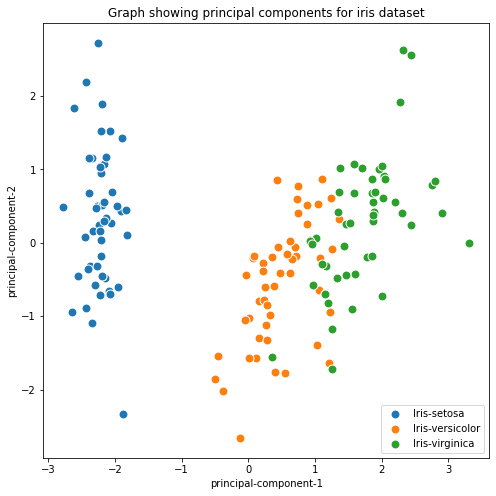

In [13]:
# Plotting the graph for the first 2 principal components

plot_graph(whole[:,0:2],whole[:,-1],numClasses=3)

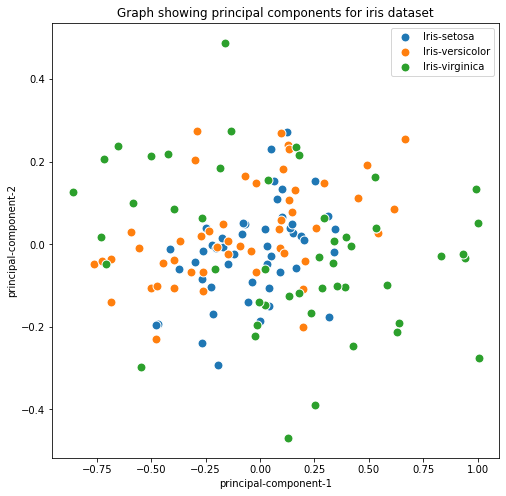

In [14]:
#Plotting the graph for the last 2 principal components

plot_graph(whole[:,2:],whole[:,-1],numClasses=3)

From the above graphs it can be said that since the first two pricipal components contain majority of the information, the data can be correctly visualized using only the first two componets. However, if we plot the data using the last two components having very less information, then the data can not be visualized correctly.

In [15]:
# The variance contained within the each principal component.
# It can be seen that the only with the first 2 principal components 95.80% variance is achieved.

pca.explained_variance_ratio_

array([0.72770452, 0.23030523, 0.03683832, 0.00515193])

In [16]:
sum(list(pca.explained_variance_ratio_))

0.9999999999999999

In [18]:
# Download the training data
train_data = datasets.MNIST('./mnist_data', download=True, train=True,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))

# Download the test data
test_data = datasets.MNIST('./mnist_data', download=True, train=False,
                            transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                            ]))
print("Training examples: ", len(train_data))
print("Test examples: ", len(test_data))

Training examples:  60000
Test examples:  10000


In [0]:
# Getting the original images from the dataset

original_Xtrain = train_data.data
original_ytrain = train_data.targets
original_Xtest = test_data.data
original_ytest = test_data.targets

In [0]:
# Simple Feedforward Neural Network with a input layer of variable size, 1 hidden layer with half the number of neurons in the 
# input layer and a softmax output layer with 10 nuerons.

class NeuralNetwork(nn.Module):
  def __init__(self,input_features):
    super(NeuralNetwork,self).__init__()

    temp = int(input_features/2)
    self.layer1 = nn.Linear(in_features=input_features,out_features=temp)
    self.out = nn.Linear(in_features=temp,out_features=10)

  def forward(self,t):
    t = self.layer1(t)
    t = F.relu(t)

    t = self.out(t)
    t = F.log_softmax(t,dim=1)
    return t

In [0]:
#Takes in arguments such as:

# epochs :- The number of iterations required during the training
# input_features :- Number of features in the input layer
# new_Xtrain :- Training images 
# new_Xtest :- Test images
# ytrain :- Labels of the training images
# ytest :- Labels of the test images

 #  Returns the loss for training the Neural Network as well as the training accuracy and test accuracy.


def eval_net(epochs,input_features,new_Xtrain,new_Xtest,ytrain,ytest):  
  
  losses = []
  train_acc = 0
  test_acc = 0

  net = NeuralNetwork(input_features)

  if(use_cuda and torch.cuda.is_available()):
    net.cuda()                                            # Passing the object to GPU
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr=0.001) 
  
  for val in range(0,epochs):                             # From here the training begins
    for i in range(len(new_Xtrain)):
      inputs = new_Xtrain[i]
      labels = ytrain[i]

      if(use_cuda and torch.cuda.is_available()):
         inputs = inputs.cuda()                         # Passing the images to GPU
         labels = labels.cuda()                         # Passing the labels to GPU
      optimizer.zero_grad()

      outputs = net(inputs.float())
      loss = criterion(outputs,labels)
      loss.backward(retain_graph=True)
      optimizer.step()
      losses.append(loss.item())

  correct = 0
  total = 0
  with torch.no_grad():                                 # Evaluating on train data
    for i in range(len(new_Xtrain)):
      inputs = new_Xtrain[i]
      labels = ytrain[i]

      if(use_cuda and torch.cuda.is_available()):
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = (correct*100) / total

  correct = 0
  total = 0
  with torch.no_grad():                               # Evaluating on test data
    for i in range(len(new_Xtest)):
      inputs = new_Xtest[i]
      labels = ytest[i]

      if(use_cuda and torch.cuda.is_available()):
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = net(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = (correct*100) / total
  return losses, train_acc, test_acc

In [0]:
# Convolutional Neural Network with 2 convolutional layers, followed by 2 maxpooling layers and 2 fully connected layer followed by the output layer.

class NetCNN(nn.Module):
  def __init__(self):
    super(NetCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 3)     # 1 channel in, 6 filters out, 3x3 filters
    self.pool = nn.MaxPool2d(2, 2)      # 2x2 pooling, with a stride of 2 (move the window by 2 pixels)
    self.conv2 = nn.Conv2d(6, 16, 3)    # 6 filters in, 16 filters out, 3x3 filters
    self.fc1 = nn.Linear(16 * 5 * 5, 120) # the 16 filtered images are reduced to 5x5 now, connect to 120 hidden units out
    self.fc2 = nn.Linear(120, 84)       # 120 hidden units in, 84 hidden units out
    self.fc3 = nn.Linear(84, 10)        # 84 hidden units in, 10 outputs units

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)          # .view() is similar to .reshape(), so this flattens x into a vector
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.log_softmax(self.fc3(x), dim=1)
    return x

In [0]:
 #  Takes epochs, batch_train_images, batch_train_labels, batch_test_images, batch_test_labels as arguments.
 #  Returns the loss for training the CNN as well as the training accuracy and test accuracy.

def eval_net_cnn(epochs,train_images,test_images,train_labels,test_labels): 

  netCNN = NetCNN()

  if(use_cuda and torch.cuda.is_available()):
    netCNN.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(netCNN.parameters(), lr=0.001) 

  losses = []
  for e in range(epochs):
      for i in range(len(train_images)):
        inputs = train_images[i]
        labels = train_labels[i]

        if(use_cuda and torch.cuda.is_available()):
          inputs = inputs.cuda()
          labels = labels.cuda()
        optimizer.zero_grad() 

        outputs = netCNN(inputs.float()) 
        loss = criterion(outputs, labels) 
        loss.backward(retain_graph=True) 
        optimizer.step() 
        losses.append(loss.item())


  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(train_images)):
      inputs = train_images[i]
      labels = train_labels[i]

      if(use_cuda and torch.cuda.is_available()):
        inputs = inputs.cuda()
        labels = labels.cuda()
      outputs = netCNN(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  train_acc = (correct*100) / total


  correct = 0
  total = 0
  with torch.no_grad():
    for i in range(len(test_images)):
      inputs = test_images[i]
      labels = test_labels[i]

      if(use_cuda and torch.cuda.is_available()):
        inputs = inputs.cuda()
        labels = labels.cuda()

      outputs = netCNN(inputs.float())
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  test_acc = (correct*100) / total
  return losses, train_acc, test_acc

Performing PCA with variance percentage = 50.0 %
Training the Neural Network...


Neural network Training Accuracy = 95.11166666666666
Neural network Test Accuracy = 94.77


Training the CNN...
CNN Training Accuracy = 97.21
CNN Test Accuracy = 96.56


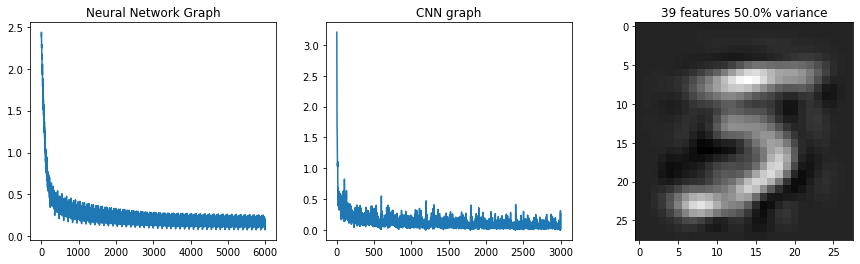

------------------------------------------------------------------------------------------------------------------------------------------------------
Performing PCA with variance percentage = 75.0 %
Training the Neural Network...


Neural network Training Accuracy = 99.38833333333334
Neural network Test Accuracy = 97.1


Training the CNN...
CNN Training Accuracy = 98.56833333333333
CNN Test Accuracy = 97.87


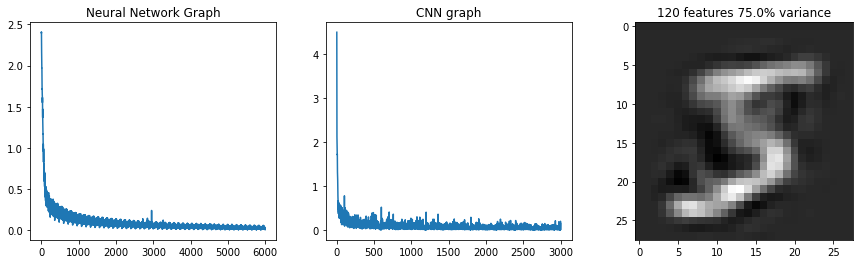

------------------------------------------------------------------------------------------------------------------------------------------------------
Performing PCA with variance percentage = 90.0 %
Training the Neural Network...


Neural network Training Accuracy = 99.99666666666667
Neural network Test Accuracy = 97.46


Training the CNN...
CNN Training Accuracy = 99.17833333333333
CNN Test Accuracy = 98.49


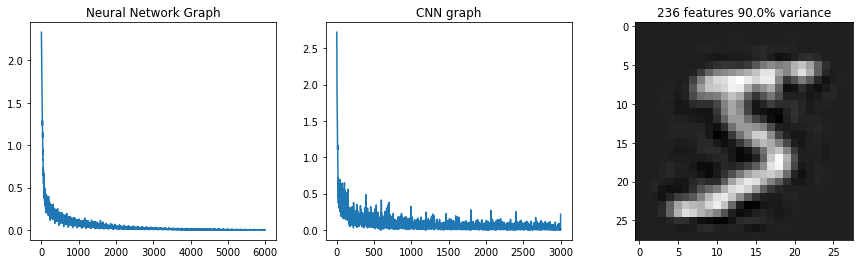

------------------------------------------------------------------------------------------------------------------------------------------------------
Performing PCA with variance percentage = 95.0 %
Training the Neural Network...


Neural network Training Accuracy = 100.0
Neural network Test Accuracy = 97.66


Training the CNN...
CNN Training Accuracy = 99.24
CNN Test Accuracy = 98.56


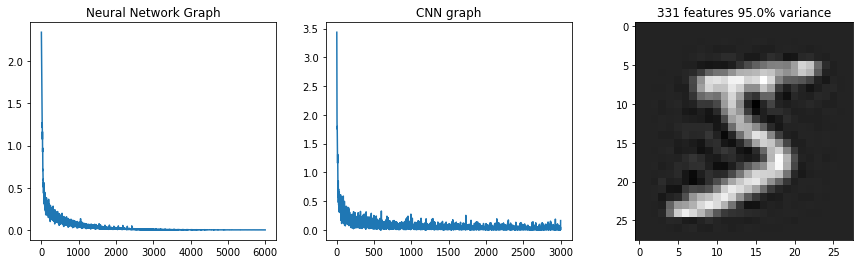

------------------------------------------------------------------------------------------------------------------------------------------------------


In [25]:
# This cell performs everyting asked in question (b). First it performs PCA with the given variance level. After performing PCA it trains the 
# Feedforward Neural Network. Then it reconstructs the images back to 28*28 and using the reconstructed images, it trains the CNN.

pca_list = [0.5,0.75,0.9,0.95]
pcaSNNTrain = []
pcaSNNTest = []
pcaCNNTrain = []
pcaCNNTest = []
components  = []

for val in pca_list:
  plt.figure(figsize=(15,4))
  Xtrain = train_data.data                                # Preparing the dataset
  ytrain = train_data.targets
  Xtest = test_data.data
  ytest = test_data.targets

  Xtrain = Xtrain.flatten(start_dim=1)
  Xtest = Xtest.flatten(start_dim=1)
  sc_X = StandardScaler()
  Xtrain = sc_X.fit_transform(Xtrain)
  Xtest = sc_X.transform(Xtest)

  pca_mnist = PCA(val)                                    # Performing the PCA
  print("Performing PCA with variance percentage =",val*100,"%")
  new_Xtrain = pca_mnist.fit_transform(Xtrain)
  new_Xtest = pca_mnist.transform(Xtest)

  components.append(pca_mnist.n_components_)

  new_Xtrain = torch.tensor(new_Xtrain)
  new_Xtest = torch.tensor(new_Xtest)

  input_features = pca_mnist.n_components_

  # Training the Neural Network after performing PCA
  snn_batch_train_images, snn_batch_test_images, snn_batch_train_labels, snn_batch_test_labels = get_batch(new_Xtrain,new_Xtest,ytrain,ytest,batch_size=500)

  print("Training the Neural Network...")
  nn_losses, nn_train_accuracy, nn_test_accuracy = eval_net(50,input_features,snn_batch_train_images, snn_batch_test_images, snn_batch_train_labels, snn_batch_test_labels)

  pcaSNNTrain.append(nn_train_accuracy)
  pcaSNNTest.append(nn_test_accuracy)
  print("\n\nNeural network Training Accuracy =",nn_train_accuracy)
  print("Neural network Test Accuracy =",nn_test_accuracy)
  plt.subplot(131)
  plt.plot(nn_losses)
  plt.title("Neural Network Graph")

  print("\n")

  #Part for CNN starts

  Xtrain = pca_mnist.inverse_transform(new_Xtrain)
  Xtest = pca_mnist.inverse_transform(new_Xtest)

  Xtrain = sc_X.inverse_transform(Xtrain)
  Xtest = sc_X.inverse_transform(Xtest)

  Xtrain = Xtrain.reshape(60000,1,28,28)
  Xtest = Xtest.reshape(10000,1,28,28)

  Xtrain = torch.tensor(Xtrain)
  Xtest = torch.tensor(Xtest)

  batch_train_images, batch_test_images, batch_train_labels, batch_test_labels = get_batch(Xtrain,Xtest,ytrain,ytest,batch_size=100)
  
  print("Training the CNN...")                            # Training the CNN using the reconstructed images
  cnn_losses, cnn_train_acc, cnn_test_acc = eval_net_cnn(5,batch_train_images, batch_test_images, batch_train_labels, batch_test_labels)
  plt.subplot(132)
  pcaCNNTrain.append(cnn_train_acc)
  pcaCNNTest.append(cnn_test_acc)
  print("CNN Training Accuracy =",cnn_train_acc)
  print("CNN Test Accuracy =",cnn_test_acc)
  plt.plot(cnn_losses)
  plt.title("CNN graph")


  plt.subplot(133)
  img = batch_train_images[0][0]
  plt.imshow(img.squeeze(dim=0),cmap="gray")              # Plotting the reconstructed image
  plt.title(str(input_features)+" features "+str(val*100)+ "% variance")
  plt.show()
  print(150*"-")


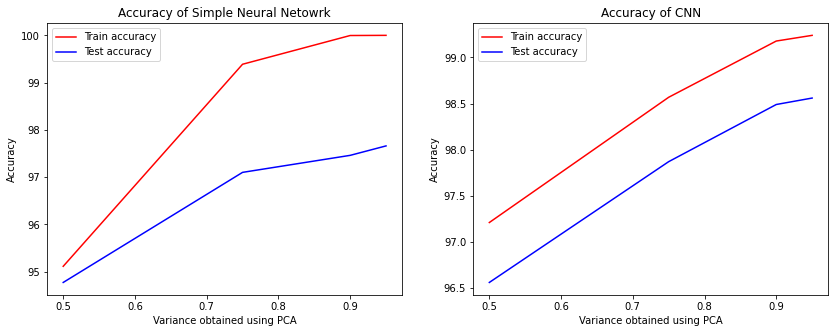

In [26]:
# Plotting the Training and Test accuracy for Simple Neural Network and CNN for different PCA variance levels

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(pca_list, pcaSNNTrain,"r-")
plt.plot(pca_list, pcaSNNTest,"b-")
plt.xlabel("Variance obtained using PCA")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of Simple Neural Netowrk")

plt.subplot(122)
plt.plot(pca_list, pcaCNNTrain,"r-")
plt.plot(pca_list, pcaCNNTest,"b-")
plt.xlabel("Variance obtained using PCA")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of CNN")
plt.show()


From the above graphs it can be said that in case of PCA both the train and test accuracy consistently increases with increase in variance level.

In [0]:
# Perparing the dataset.

Xtrain = train_data.data
ytrain = train_data.targets
Xtest = test_data.data
ytest = test_data.targets


Xtrain = Xtrain.flatten(start_dim=1)
Xtest = Xtest.flatten(start_dim=1)


enc_batch_train_images, enc_batch_train_labels, enc_batch_test_images, enc_batch_test_labels = get_batch(Xtrain, Xtest, ytrain, ytest,100)

In [0]:
# Below is the class for Linear AutoEncoder. Input layer has 784 neurons, hidden layer has nuerons equal to number of features as per PCA and output
# layer has 784 neurons.

# While performing PCA it has been observed that: 
# 50% variance = 39 features
# 75% variance = 120 features
# 90% variance = 236 features
# 95% variance = 331 features


class autoEncoder(nn.Module):
  def __init__(self,intermediate):
    super(autoEncoder,self).__init__()

    self.encodeInput = nn.Linear(in_features=784,out_features=intermediate)
    self.decodeOutput = nn.Linear(in_features=intermediate, out_features=784)

  def forward(self,t):

    t = self.encodeInput(t)
    t = self.decodeOutput(t)
    return t
  
  def encode(self,t):
    t = self.encodeInput(t)
    return t

  def decode(self,t):
    t = self.decodeOutput(t)
    return t




Training the linear autoencoder for retaining 39 features
Training the Feedforward Neural Network...
Training accuracy for simple neural network = 94.78666666666666
Test accuracy for simple neural network = 94.43


Training the CNN...
Training accuracy for CNN = 98.49833333333333
Test accuracy for CNN = 97.74


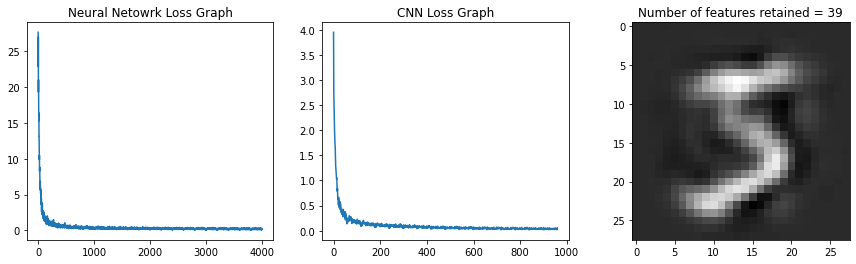

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the linear autoencoder for retaining 120 features
Training the Feedforward Neural Network...
Training accuracy for simple neural network = 98.34
Test accuracy for simple neural network = 96.14


Training the CNN...
Training accuracy for CNN = 99.53666666666666
Test accuracy for CNN = 98.49


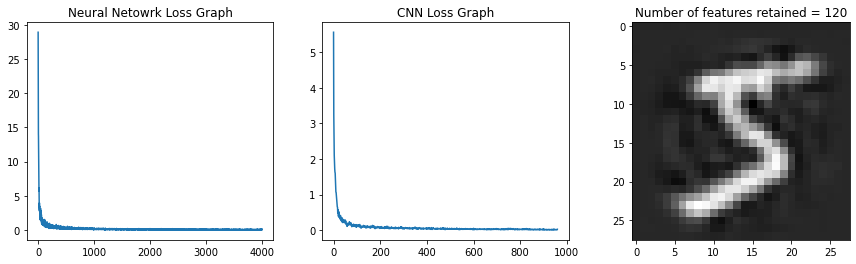

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the linear autoencoder for retaining 236 features
Training the Feedforward Neural Network...
Training accuracy for simple neural network = 99.405
Test accuracy for simple neural network = 96.37


Training the CNN...
Training accuracy for CNN = 99.41666666666667
Test accuracy for CNN = 98.7


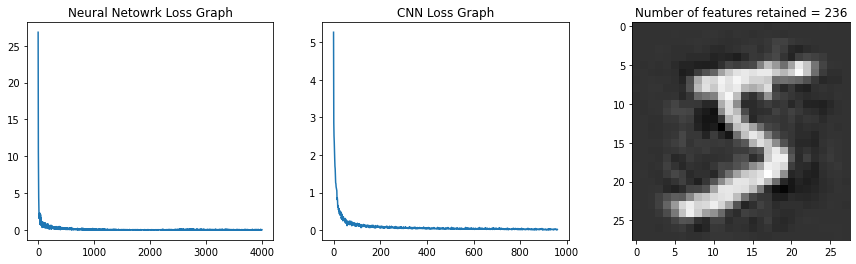

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the linear autoencoder for retaining 331 features
Training the Feedforward Neural Network...
Training accuracy for simple neural network = 99.38833333333334
Test accuracy for simple neural network = 96.69


Training the CNN...
Training accuracy for CNN = 98.57833333333333
Test accuracy for CNN = 98.07


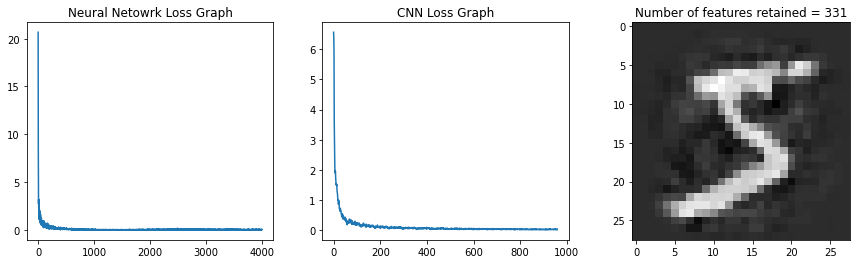

------------------------------------------------------------------------------------------------------------------------------------------------------


In [29]:
# This cell peroforms everyting asked in question (c). First it train the linear autoencoder with the given number of features. 
# After encoding the images, they are given as an input to the Feedforward Neural Network.
# Then it reconstructs the images using  decoder to 28*28 and using the reconstructed images, it trains the CNN.

features = [39, 120, 236, 331]        # Number of fetures = variance level as per PCA
linearEncSNNTrain = []
linearEncSNNTest = []
linearEncCNNTrain = []
linearEncCNNTest = []
Xtrain = Xtrain.cuda()
Xtest = Xtest.cuda()
  
for num in features:
  print("\n\n")

  print("Training the linear autoencoder for retaining",num,"features")
  enc = autoEncoder(intermediate=num)                     
  if(use_cuda and torch.cuda.is_available()):
    enc.cuda()

  optimizer = optim.Adam(enc.parameters(), lr=0.001) 
  criterion = nn.MSELoss()
  epochs = 40
  enc_losses = []
  for e in range(epochs):                                       # Training the AutoEncoder 
    for i in range(len(enc_batch_train_images)):
      inputs = enc_batch_train_images[i]

      if(use_cuda and torch.cuda.is_available()):
          inputs = inputs.cuda()
      optimizer.zero_grad()
      enc_preds = enc(inputs.float())
      loss = criterion(enc_preds,inputs.float())
      enc_losses.append(loss.item())
      loss.backward(retain_graph=True)
      optimizer.step()
  plt.figure(figsize=(15,4))

  # Part for training the Simple Neural Network starts from here

  tr_data = enc.encode(Xtrain.float())
  ts_data = enc.encode(Xtest.float())
  n_batch_train_images, n_batch_test_images, n_batch_train_labels, n_batch_test_labels = get_batch(tr_data,ts_data,ytrain,ytest,batch_size=300)

  print("Training the Feedforward Neural Network...")
  losses, train_accuracy, test_accuracy = eval_net(20,num,n_batch_train_images, n_batch_test_images, n_batch_train_labels, n_batch_test_labels)
  plt.subplot(131)
  plt.title("Neural Netowrk Loss Graph")

  plt.plot(losses)
  linearEncSNNTrain.append(train_accuracy)
  linearEncSNNTest.append(test_accuracy)
  print("Training accuracy for simple neural network =", train_accuracy)
  print("Test accuracy for simple neural network =", test_accuracy)
  
  print("\n")

  # Part for training the CNN starts from here

  cnn_train = enc.decode(tr_data)
  cnn_test = enc.decode(ts_data)
  cnn_train = cnn_train.reshape(60000,1,28,28)
  cnn_test = cnn_test.reshape(10000,1,28,28)
  batch_train_images, batch_test_images, batch_train_labels, batch_test_labels = get_batch(cnn_train,cnn_test,ytrain,ytest,1000)

  print("Training the CNN...")
  losses, train_acc, test_acc = eval_net_cnn(16,batch_train_images, batch_test_images, batch_train_labels, batch_test_labels)
  plt.subplot(132)
  plt.title("CNN Loss Graph")
  plt.plot(losses)
  # plt.show()
  linearEncCNNTrain.append(train_acc)
  linearEncCNNTest.append(test_acc)
  print("Training accuracy for CNN =", train_acc)
  print("Test accuracy for CNN =", test_acc)

  plt.subplot(133)                                          # Plotting the reconstructed image 
  compressed = enc.encode(Xtrain.float())
  reconstructed = enc.decode(compressed)
  image = reconstructed[0].clone().detach()                 
  image = image.cpu().data.numpy()                          # Taking the image back in CPU from the GPU to plot
  title_string = "Number of features retained = "+str(num)
  plt.imshow((image).reshape(28,28),cmap="gray")
  plt.title(title_string)
  plt.show()

  print(150*"-")

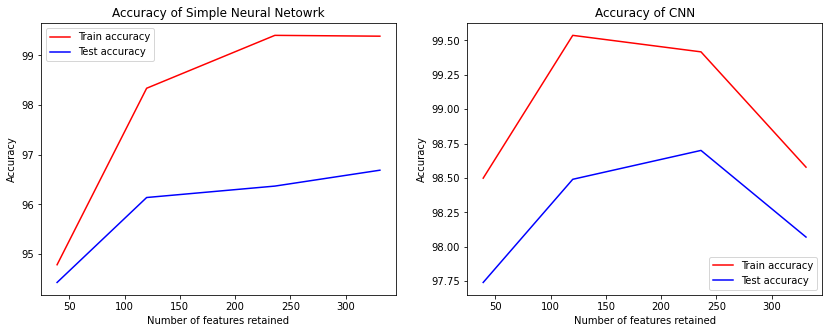

In [30]:
# Plotting the Training and Test accuracy for Simple Neural Network and CNN for different number of features as per PCA variance levels

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(features, linearEncSNNTrain,"r-")
plt.plot(features, linearEncSNNTest,"b-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of Simple Neural Netowrk")

plt.subplot(122)
plt.plot(features, linearEncCNNTrain,"r-")
plt.plot(features, linearEncCNNTest,"b-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of CNN")
plt.show()

From the above graphs it can be said that in case of Linear AutoEncoder both the train and test accuracy increases with increase in number of features retained.

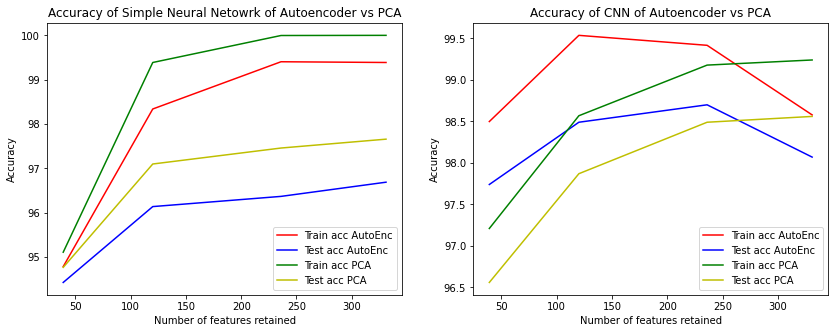

In [31]:
# Comparing the accuracy obtained from PCA and Linear AutoEncoder

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(features, linearEncSNNTrain,"r-")
plt.plot(features, linearEncSNNTest,"b-")
plt.plot(features, pcaSNNTrain,"g-")
plt.plot(features, pcaSNNTest,"y-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train acc AutoEnc","Test acc AutoEnc", "Train acc PCA","Test acc PCA"])
plt.title("Accuracy of Simple Neural Netowrk of Autoencoder vs PCA")

plt.subplot(122)
plt.plot(features, linearEncCNNTrain,"r-")
plt.plot(features, linearEncCNNTest,"b-")
plt.plot(features, pcaCNNTrain,"g-")
plt.plot(features, pcaCNNTest,"y-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train acc AutoEnc","Test acc AutoEnc", "Train acc PCA","Test acc PCA"])
plt.title("Accuracy of CNN of Autoencoder vs PCA")
plt.show()

It can be clearly said from the above graph that PCA consistently performs better than Linear AutoEncoder in terms of Simple Neural Network. However in case of CNN, the perfomance of PCA and Linear AutoEncoder is almost similar.

In [0]:
# Preparing the dataset

Xtrain = train_data.data
ytrain = train_data.targets
Xtest = test_data.data
ytest = test_data.targets
Xtrain = Xtrain.flatten(start_dim=1)
Xtest = Xtest.flatten(start_dim=1)

batch_train_images_nl, batch_train_labels_nl, batch_test_images_nl, batch_test_labels_nl = get_batch(Xtrain, Xtest, ytrain, ytest,100)

Text(0.5, 1.0, 'ORIGINAL IMAGE')

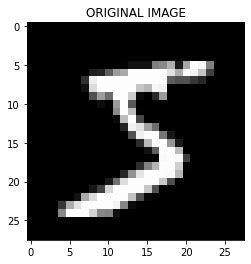

In [33]:
# Plotting the original image for visualization

img = batch_train_images_nl[0][0]
plt.imshow(img.reshape(28,28),cmap="gray")
plt.title("ORIGINAL IMAGE")

In [0]:
# Below is the class for Non-Linear AutoEncoder. Input layer has 784 neurons, hidden layer has nuerons equal to number of features as per PCA and output
# layer has 784 neurons.
# The non-linear activation function that is used is "RELU".


class autoEncoderNonLinear(nn.Module):
  def __init__(self,inter):
    super(autoEncoderNonLinear,self).__init__()

    self.encodeInput = nn.Linear(in_features=784,out_features=inter)
    self.decodeOutput = nn.Linear(in_features=inter, out_features=784)

  def forward(self,t):

    t = F.relu(self.encodeInput(t))
    t = F.relu(self.decodeOutput(t))
    return t
  
  def encode(self,t):
    t = F.relu(self.encodeInput(t))
    return t

  def decode(self,t):
    t = F.relu(self.decodeOutput(t))
    return t




Training the Non-Linear AutoEncoder for retaining 39 features
Training the Neural Network...
Training accuracy for simple neural network 76.395
Test accuracy for simple neural network 77.09
Training the CNN...
Training accuracy for CNN = 98.70666666666666
Test accuracy for CNN = 97.88


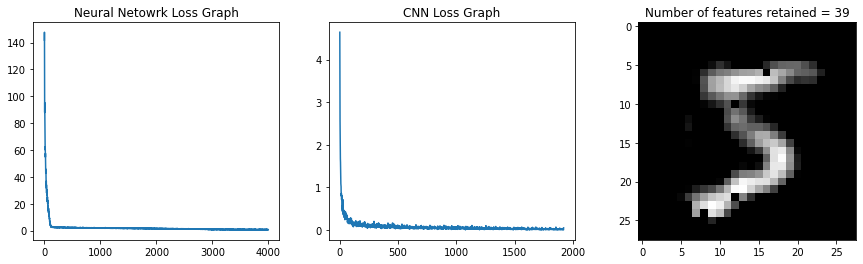

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the Non-Linear AutoEncoder for retaining 120 features
Training the Neural Network...
Training accuracy for simple neural network 93.215
Test accuracy for simple neural network 92.92
Training the CNN...
Training accuracy for CNN = 99.08
Test accuracy for CNN = 97.9


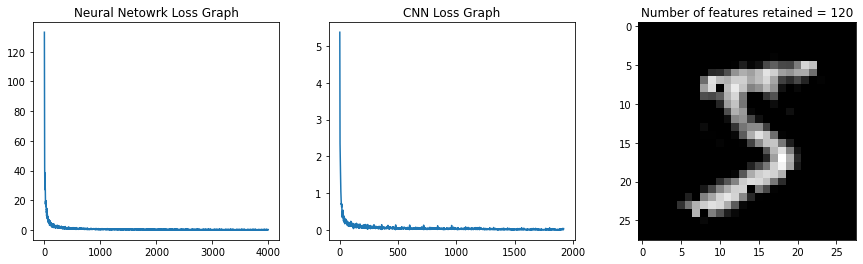

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the Non-Linear AutoEncoder for retaining 236 features
Training the Neural Network...
Training accuracy for simple neural network 95.71333333333334
Test accuracy for simple neural network 94.57
Training the CNN...
Training accuracy for CNN = 98.815
Test accuracy for CNN = 97.76


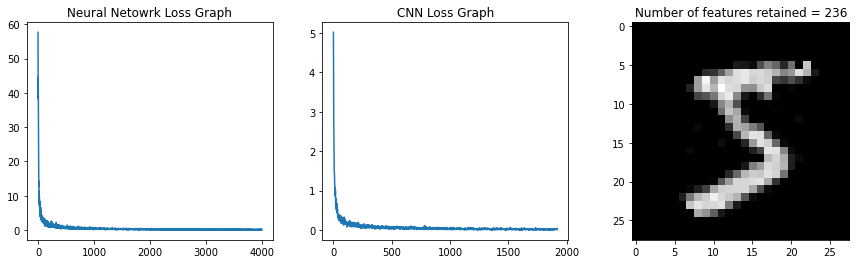

------------------------------------------------------------------------------------------------------------------------------------------------------



Training the Non-Linear AutoEncoder for retaining 331 features
Training the Neural Network...
Training accuracy for simple neural network 95.41333333333333
Test accuracy for simple neural network 94.77
Training the CNN...
Training accuracy for CNN = 99.135
Test accuracy for CNN = 98.11


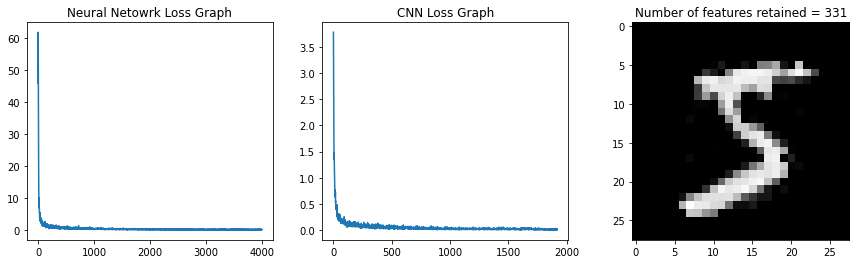

------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
# This cell peroforms everyting asked in question (d). First it train the non-linear autoencoder with the given number of features. 
# After encoding the images, they are given as an input to the Feedforward Neural Network.
# Then in reconstructs the images using decoder to 28*28 and using the reconstructed images, it trains the CNN.

features = [39, 120, 236, 331]
nonLinearEncSNNTrain = []
nonLinearEncSNNTest = []
nonLinearEncCNNTrain = []
nonLinearEncCNNTest = []
Xtrain = Xtrain.cuda()
Xtest = Xtest.cuda()

for num in features:
  print("\n\n")
  encnl = autoEncoderNonLinear(num)

  if(use_cuda and torch.cuda.is_available()):
    encnl.cuda()
  optimizer = optim.Adam(encnl.parameters(), lr=0.001) 
  criterion = nn.MSELoss()
  epochs = 40
  losses = []

  print("Training the Non-Linear AutoEncoder for retaining",num,"features")
  for e in range(epochs):
    for i in range(len(batch_train_images_nl)):
      inputs = batch_train_images_nl[i]
      if(use_cuda and torch.cuda.is_available()):
        inputs = inputs.cuda()

      optimizer.zero_grad()
      enc_preds = encnl(inputs.float())
      loss = criterion(enc_preds,inputs.float())
      losses.append(loss.item())
      loss.backward(retain_graph=True)
      optimizer.step()

  plt.figure(figsize=(15,4))
  nl_tr_data = encnl.encode(Xtrain.float())
  nl_ts_data = encnl.encode(Xtest.float())

  train_encnl_img, test_encnl_img, train_encnl_labels, test_encnl_labels = get_batch(nl_tr_data,nl_ts_data,ytrain,ytest,batch_size=300)

  print("Training the Neural Network...")
  nl_losses, nl_train_accuracy, nl_test_accuracy = eval_net(20,num,train_encnl_img, test_encnl_img, train_encnl_labels, test_encnl_labels)
  plt.subplot(131)
  plt.title("Neural Netowrk Loss Graph")
  plt.plot(nl_losses)
  # plt.show()
  nonLinearEncSNNTrain.append(nl_train_accuracy)
  nonLinearEncSNNTest.append(nl_test_accuracy)

  print("Training accuracy for simple neural network", nl_train_accuracy)
  print("Test accuracy for simple neural network", nl_test_accuracy)


  reconstructed_nl_train = encnl.decode(nl_tr_data)
  reconstructed_nl_test = encnl.decode(nl_ts_data)
  reconstructed_nl_train = reconstructed_nl_train.reshape(60000,1,28,28)
  reconstructed_nl_test = reconstructed_nl_test.reshape(10000,1,28,28)

  tr_img, ts_img, tr_labels, ts_labels = get_batch(reconstructed_nl_train,reconstructed_nl_test,ytrain,ytest,batch_size=500)

  print("Training the CNN...")
  losses, train_acc, test_acc = eval_net_cnn(16,tr_img, ts_img, tr_labels, ts_labels)
  plt.subplot(132)
  plt.title("CNN Loss Graph")
  plt.plot(losses)
  # plt.show()

  nonLinearEncCNNTrain.append(train_acc)
  nonLinearEncCNNTest.append(test_acc)
  print("Training accuracy for CNN =", train_acc)
  print("Test accuracy for CNN =", test_acc)


  plt.subplot(133)
  compressed_nl = encnl.encode(Xtrain.float())
  reconstructed_nl = encnl.decode(compressed_nl)
  image = reconstructed_nl[0].clone().detach()
  image = image.cpu().data.numpy()
  plt.imshow((image).reshape(28,28),cmap="gray")
  title_string = "Number of features retained = "+str(num)
  plt.title(title_string)

  plt.show()
  print(150*"-")

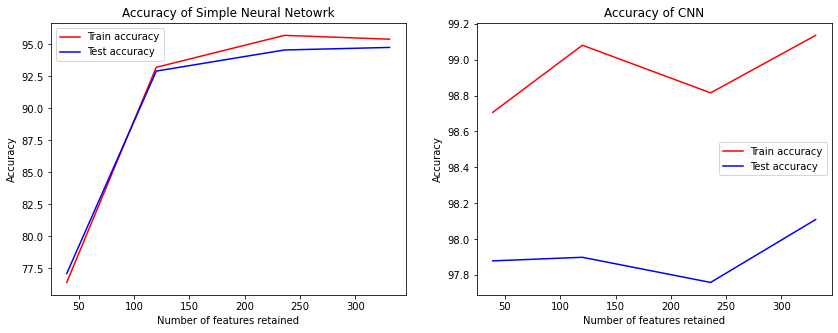

In [36]:
# Plotting the Training and Test accuracy for Simple Neural Network and CNN for different number of features as per PCA variance levels

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(features, nonLinearEncSNNTrain,"r-")
plt.plot(features, nonLinearEncSNNTest,"b-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of Simple Neural Netowrk")

plt.subplot(122)
plt.plot(features, nonLinearEncCNNTrain,"r-")
plt.plot(features, nonLinearEncCNNTest,"b-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train accuracy","Test accuracy"])
plt.title("Accuracy of CNN")
plt.show()

From the above graphs it can be said that in case of Non-Linear AutoEncoder both the train and test accuracy increases with increase in number of features retained.

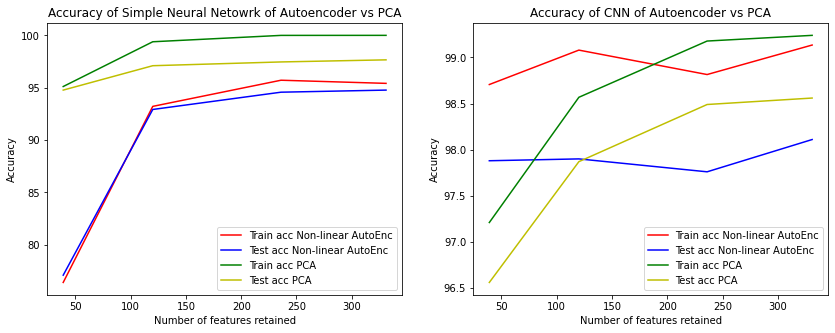

In [37]:
# Comparing the accuracy obtained from PCA and Non-Linear AutoEncoder

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(features, nonLinearEncSNNTrain,"r-")
plt.plot(features, nonLinearEncSNNTest,"b-")
plt.plot(features, pcaSNNTrain,"g-")
plt.plot(features, pcaSNNTest,"y-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train acc Non-linear AutoEnc","Test acc Non-linear AutoEnc", "Train acc PCA","Test acc PCA"])
plt.title("Accuracy of Simple Neural Netowrk of Autoencoder vs PCA")

plt.subplot(122)
plt.plot(features, nonLinearEncCNNTrain,"r-")
plt.plot(features, nonLinearEncCNNTest,"b-")
plt.plot(features, pcaCNNTrain,"g-")
plt.plot(features, pcaCNNTest,"y-")
plt.xlabel("Number of features retained")
plt.ylabel("Accuracy")
plt.legend(["Train acc Non-linear AutoEnc","Test acc Non-linear AutoEnc", "Train acc PCA","Test acc PCA"])
plt.title("Accuracy of CNN of Autoencoder vs PCA")
plt.show()

[From the above graph it can be said that PCA clearly performs better than the Non-Linear AutoEncoder in case of Simple Neural Network. However, in case of CNN, both PCA and Non-Linear AutoEncoder have similar performances.

In [38]:
print("Training the Non-Linear AutoEncoder...")
encnl = autoEncoderNonLinear(39)

if(use_cuda and torch.cuda.is_available()):
  encnl.cuda()
optimizer = optim.Adam(encnl.parameters(), lr=0.001) 
criterion = nn.MSELoss()
epochs = 40
losses = []
for e in range(epochs):
  for i in range(len(batch_train_images_nl)):
    inputs = batch_train_images_nl[i]
    if(use_cuda and torch.cuda.is_available()):
      inputs = inputs.cuda()

    optimizer.zero_grad()
    enc_preds = encnl(inputs.float())
    loss = criterion(enc_preds,inputs.float())
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer.step()
print("Training Completed!!!")

Training the Non-Linear AutoEncoder...
Training Completed!!!


In [0]:
# Getting the noisy images with 90% variance

Xtrain = Xtrain.cuda()
Xtest = Xtest.cuda()
nl_tr_data = encnl.encode(Xtrain.float())
nl_ts_data = encnl.encode(Xtest.float())

reconstructed_nl_train = encnl.decode(nl_tr_data)
reconstructed_nl_test = encnl.decode(nl_ts_data)

noisy_tr_img, noisy_ts_img, noisy_tr_labels, noisy_ts_labels = get_batch(reconstructed_nl_train,reconstructed_nl_test,ytrain,ytest,batch_size=500)

In [0]:
# Getting the original clean images

Xtrain = train_data.data
ytrain = train_data.targets
Xtest = test_data.data
ytest = test_data.targets
Xtrain = Xtrain.flatten(start_dim=1)
Xtest = Xtest.flatten(start_dim=1)

clean_tr_img, clean_ts_img, clean_tr_labels, clean_ts_labels = get_batch(Xtrain, Xtest, ytrain, ytest,500)

Text(0.5, 1.0, 'Clean Image')

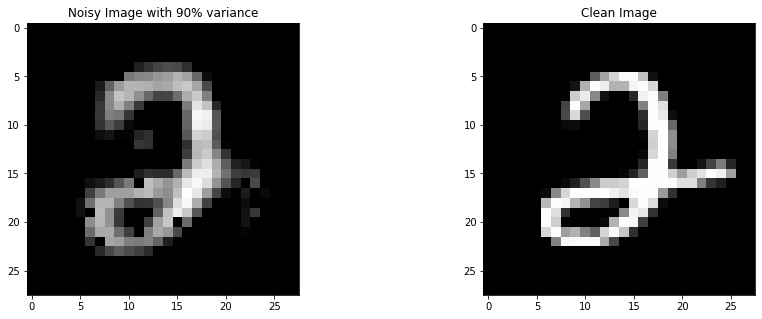

In [41]:
# Comparing the noisy and original clean images

plt.figure(figsize=(15,5))
plt.subplot(121)
noisy_image = noisy_tr_img[0][16]
noisy_image  = noisy_image.squeeze(dim=0)
noisy_image = noisy_image.cpu().data.numpy()
plt.imshow(noisy_image.reshape(28,28),cmap="gray")
plt.title("Noisy Image with 90% variance")

plt.subplot(122)
clean_image = clean_tr_img[0][16]
clean_image = clean_image.squeeze(dim=0)
clean_image = clean_image.cpu().data.numpy()
plt.imshow(clean_image.reshape(28,28),cmap="gray")
plt.title("Clean Image")

In [0]:
# Below is a De-Noising AutoEncoder with input layer having 784 neurons, intermediate layer having 400 neurons and output layer having 784 neurons

class DenoisingAutoEncoder(nn.Module):
  def __init__(self):
    super(DenoisingAutoEncoder,self).__init__()
    self.InputHidden = nn.Linear(in_features=784,out_features=400,bias=True)
    self.DecodeOutput = nn.Linear(in_features=400,out_features=784,bias=True)
  
  def forward(self,t):
    t = self.InputHidden(t)
    t = F.leaky_relu(t)

    t = self.DecodeOutput(t)
    t = F.leaky_relu(t)

    return t
  
  def encode(self,t):
    t = self.InputHidden(t)
    t = F.leaky_relu(t)
    return t

  def decode(self,t):
    t= self.DecodeOutput(t)
    t = F.leaky_relu(t)
    return t 

In [43]:
# Training the De-noising AutoEncoder with 50 epochs

print("Training the De-Noising AutoEncoder...")
den = DenoisingAutoEncoder()
den.cuda()
noisy_losses = []
optimizer = optim.Adam(den.parameters(),lr=0.001)
criterion = nn.MSELoss()
epochs = 50
for e in range (0,epochs):
  for i in range(0,len(noisy_tr_img)):
    inputs = noisy_tr_img[i]
    labels = clean_tr_img[i]

    if(use_cuda == True and torch.cuda.is_available()):
      inputs = inputs.cuda()
      labels = labels.cuda()
    
    optimizer.zero_grad()
    outputs = den(inputs.float())
    loss = criterion(outputs,labels.float())
    noisy_losses.append(loss.item())

    loss.backward(retain_graph=True)
    optimizer.step()
print("Training completed!!!")

Training the De-Noising AutoEncoder...
Training completed!!!


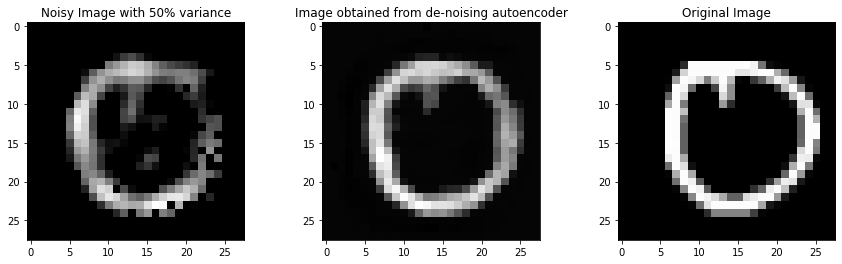

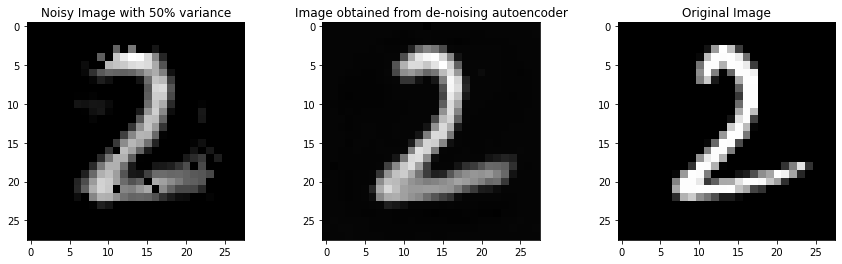

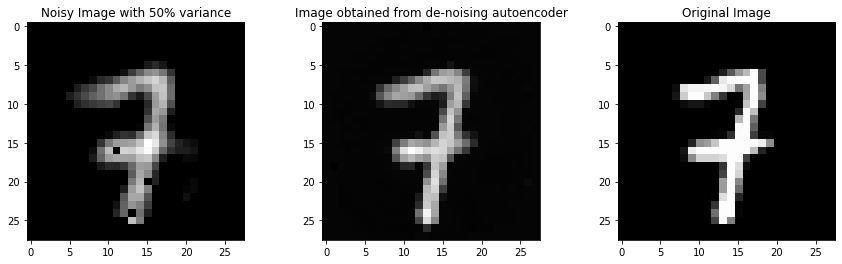

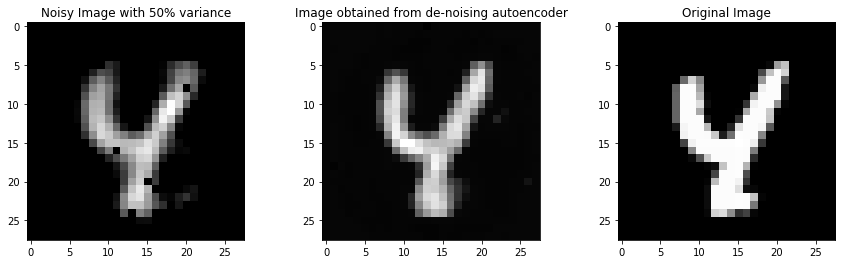

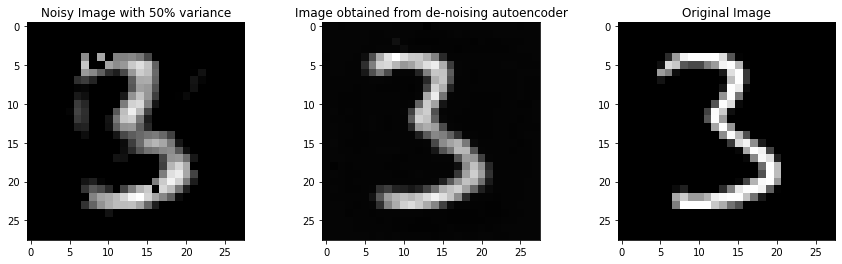

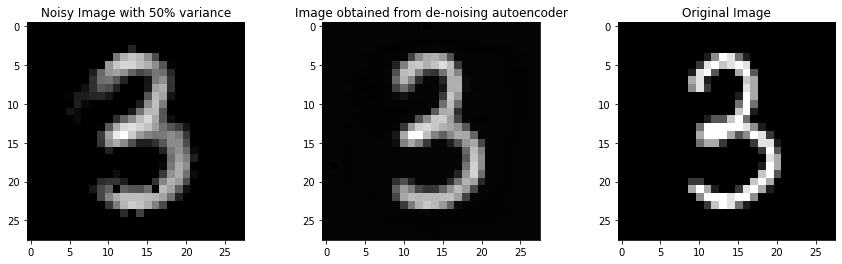

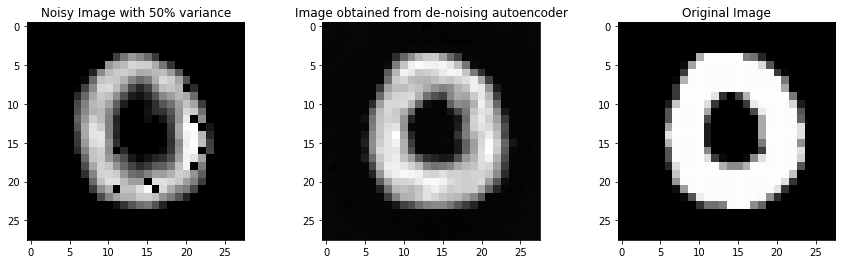

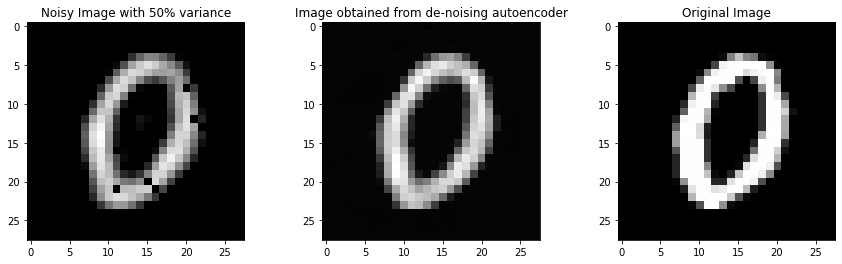

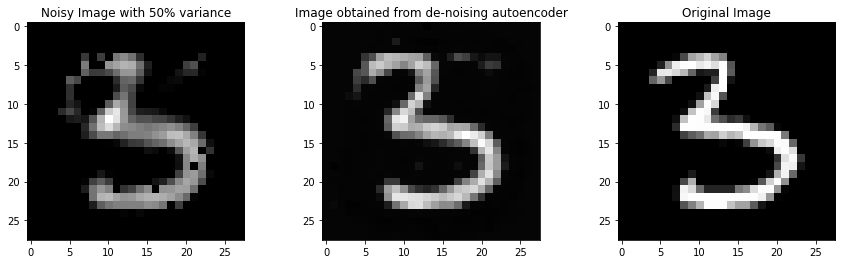

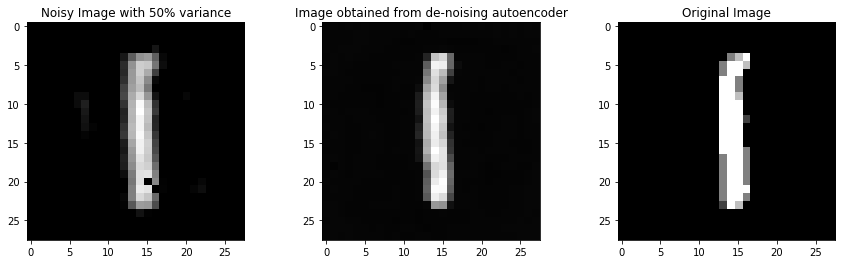

In [44]:
# Visualizing and comparing the result of De-noising AutoEncoder with Noisy and Original Image

for i in range(305,315):
  plt.figure(figsize=(15,4))
  plt.subplot(131)
  noisy_test_image = noisy_ts_img[0][i]
  noisy_test_image = noisy_test_image.cpu().data
  plt.imshow(noisy_test_image.reshape(28,28),cmap="gray")
  plt.title("Noisy Image with 50% variance")

  plt.subplot(132)
  encoded = den.encode(noisy_ts_img[0][i])
  decoded_clean = den.decode(encoded)
  decoded_clean = decoded_clean.cpu().data.numpy()
  plt.imshow(decoded_clean.reshape(28,28),cmap="gray")
  plt.title("Image obtained from de-noising autoencoder")

  plt.subplot(133)
  clean_image = clean_ts_img[0][i]
  clean_image = clean_image.squeeze(dim=0)
  clean_image = clean_image.cpu().data.numpy()
  plt.imshow(clean_image.reshape(28,28),cmap="gray")
  plt.title("Original Image")

Training accuracy for CNN = 98.405
Test accuracy for CNN = 97.29


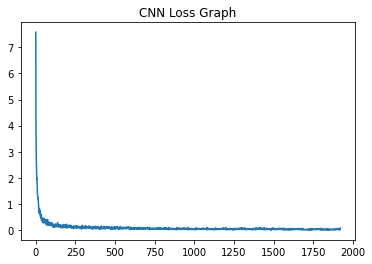

In [45]:
# Training the CNN on the De-Noised Images obtained when variance is 90%

Xtrain = Xtrain.cuda()
Xtest = Xtest.cuda()
den_tr_img = den.encode(Xtrain.float())
den_ts_img = den.encode(Xtest.float())

reconstructed_den_train = den.decode(den_tr_img)
reconstructed_den_test = den.decode(den_ts_img)

reconstructed_den_train = reconstructed_den_train.reshape(60000,1,28,28)
reconstructed_den_test = reconstructed_den_test.reshape(10000,1,28,28)

cnn_den_tr_img, cnn_den_ts_img, cnn_den_tr_labels, cnn_den_ts_labels = get_batch(reconstructed_den_train,reconstructed_den_test,ytrain,ytest,batch_size=500)
losses, train_acc, test_acc = eval_net_cnn(16,cnn_den_tr_img, cnn_den_ts_img, cnn_den_tr_labels, cnn_den_ts_labels)
plt.title("CNN Loss Graph")
plt.plot(losses)
# plt.show()
print("Training accuracy for CNN =", train_acc)
print("Test accuracy for CNN =", test_acc)
                                                                              

**References**

[PCA BLOG Post](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

[Pytorch Documentation](https://pytorch.org/)

[CNN using Pytorch](https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG)

[Using GPU in colab](https://jovianlin.io/pytorch-with-gpu-in-google-colab/)